In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageChops, ImageEnhance
import glob
import random
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [3]:
image_size=(128,128)
lr=1e-4
epochs = 10
batch_size = 32

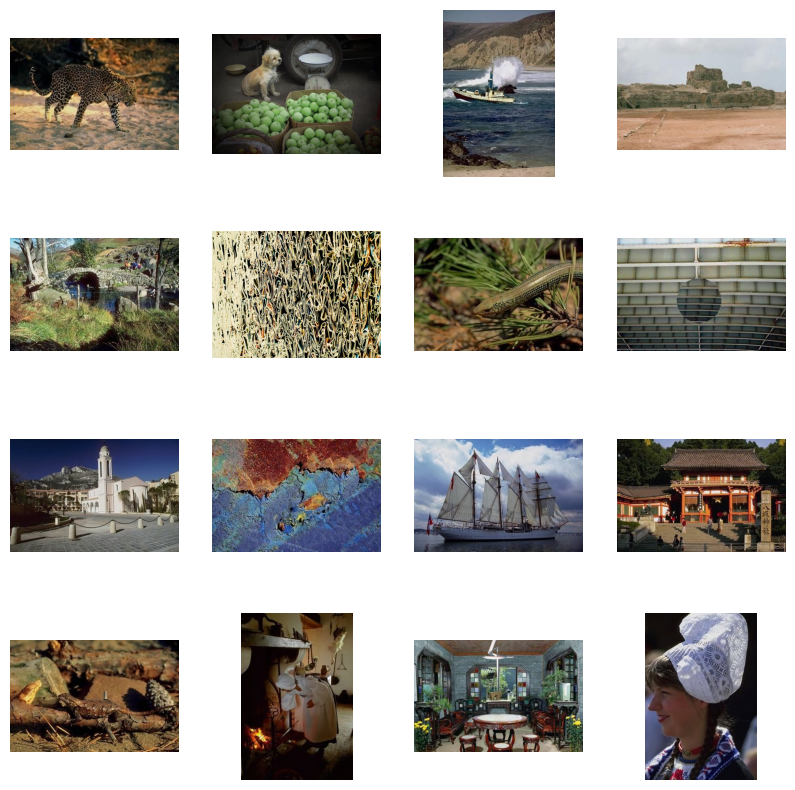

In [4]:
folder="D:/Fraud Assignment/Fraud_Assignment_HA/casia/"
paths=glob.glob(folder+"*/*/*.jpg")
_, axes = plt.subplots(4, 4, figsize=(10, 10))
random.shuffle(paths)
for ax, img_path in zip(axes.flatten(), paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [5]:
def convert_to_ela_image(image_path, quality=90):
    # Save the image at the given quality
    temp_file = 'temp.jpg'
    im = Image.open(image_path).convert('RGB')
    im.save(temp_file, 'JPEG', quality=quality)

    # Open the saved image and the original image
    saved = Image.open(temp_file)
    orignal = Image.open(image_path)

    # Find the absolute difference between the images
    diff = ImageChops.difference(orignal, saved)

    # Normalize the difference by multiplying with a scale factor and convert to grayscale
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)

    # Remove the temporary file
    os.remove(temp_file)

    return diff

In [6]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path).resize(image_size)).flatten() / 255.0

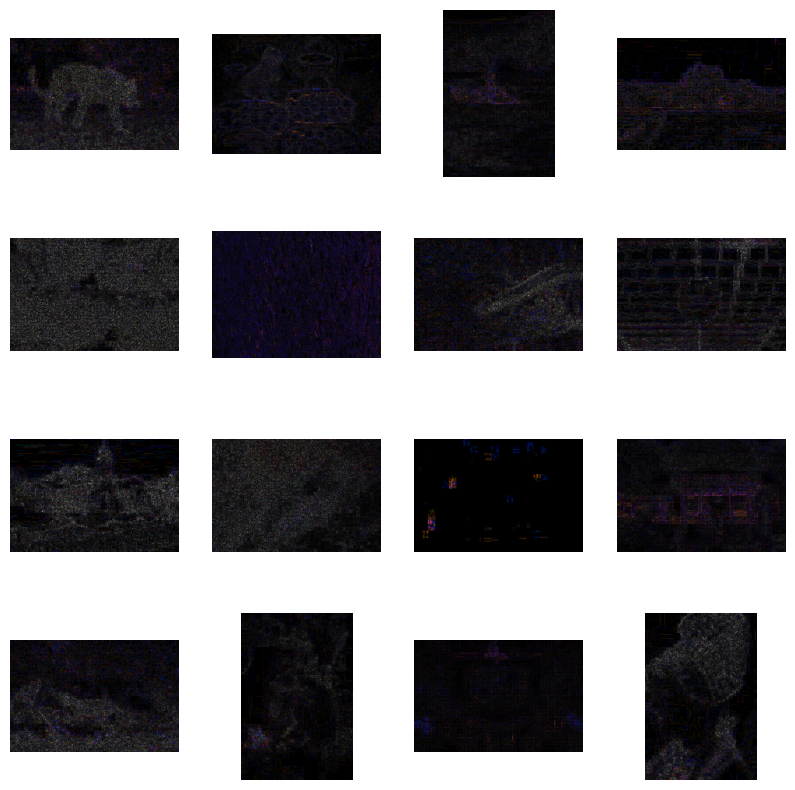

In [7]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), paths):
    ax.imshow(convert_to_ela_image(img_path))
    ax.axis("off")

Creating train and validation data array

In [8]:
X=[]    #Stores images
Y=[]    #Stores classification 1 for real, 0 for fake
temp=[] #For data augmentation

In [9]:
folder = 'D:/Fraud Assignment/Fraud_Assignment_HA/casia/CASIA2/Au/'
paths=glob.glob(folder+"*.jpg")
paths.append(glob.glob(folder+"*.png"))
paths=paths[0:7000]
random.shuffle(paths)
paths=paths[0:6000]          #So that data is not skewed towards one type
for path in paths:
    X.append(prepare_image(path))
    Y.append(1)
    if len(Y) % 500 == 0:
        print(f'Processing {len(Y)} images')

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images


In [10]:
folder = 'D:/Fraud Assignment/Fraud_Assignment_HA/casia/CASIA2/Tp/'
paths=glob.glob(folder+"*.jpg")
paths.append(glob.glob(folder+"*.png"))
paths=paths[0:2000]
for path in paths:
    temp.append(prepare_image(path))

In [11]:
#Data Augmentation

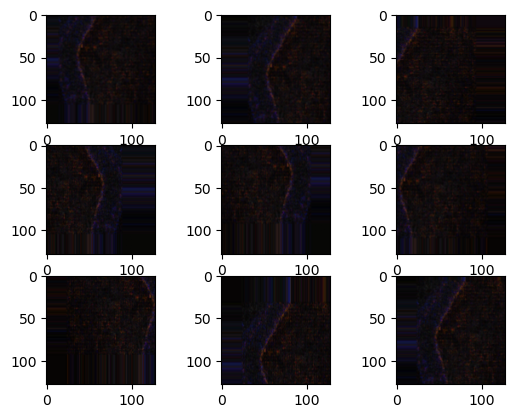

In [12]:
datagen = ImageDataGenerator(height_shift_range=0.3,width_shift_range=0.3,horizontal_flip=True)

samples = temp[0].reshape(1,128, 128, 3)
it = datagen.flow(samples, batch_size=1)
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

In [13]:
datagen = ImageDataGenerator(height_shift_range=0.3,width_shift_range=0.3,horizontal_flip=True)
for cnt,img in enumerate(temp):
    samples = img.reshape(1,128, 128, 3)
    it = datagen.flow(samples, batch_size=1)
    for i in range(3):
        batch = it.next()
        image = batch[0]
        X.append(image.flatten())
        Y.append(0)
    if (cnt+1)%250==0: print(f'Processing {cnt+1} images')

Processing 250 images
Processing 500 images
Processing 750 images
Processing 1000 images
Processing 1250 images
Processing 1500 images
Processing 1750 images
Processing 2000 images


In [14]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(f'No of elements in train dataset {len(X_train)}')
print(f'No of elements in validation dataset {len(X_val)}')
print(f'Total no of elements {len(X)}')
X = X.reshape(-1,1,1,1)

No of elements in train dataset 9600
No of elements in validation dataset 2400
Total no of elements 12000


In [16]:
#Creating a model

In [17]:
def define_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    optimizer = Adam(learning_rate = lr, decay = lr/epochs)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [18]:
model = define_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [19]:
def summarize_diagnostics(history):
    fig,ax=plt.subplots(2)
    fig.suptitle("Loss")
    fig.tight_layout()
    # plot loss
    ax[0].set_title('Cross Entropy Loss')
    ax[0].plot(history.history['loss'], color='blue', label='Training loss')
    ax[0].plot(history.history['val_loss'], color='orange', label='validation loss')
    ax[0].legend(loc='best', shadow=True)
    # plot accuracy
    ax[1].set_title('Classification Accuracy')
    ax[1].plot(history.history['accuracy'], color='blue', label='train')
    ax[1].plot(history.history['val_accuracy'], color='orange', label='test')
    ax[1].legend(loc='best', shadow=True)
    
def print_confusion_metric(y_true, y_preds):
    cm = confusion_matrix(y_true, y_preds, normalize='all')
    cmd = ConfusionMatrixDisplay(cm, display_labels=['AI Image','Real Image'])
    cmd.plot()

In [20]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/10
300/300 [==============================] - 236s 781ms/step - loss: 0.2887 - accuracy: 0.8836 - val_loss: 0.1960 - val_accuracy: 0.9333
Epoch 2/10
300/300 [==============================] - 228s 761ms/step - loss: 0.2006 - accuracy: 0.9336 - val_loss: 0.1773 - val_accuracy: 0.9371
Epoch 3/10
300/300 [==============================] - 228s 762ms/step - loss: 0.1752 - accuracy: 0.9406 - val_loss: 0.1582 - val_accuracy: 0.9404
Epoch 4/10
300/300 [==============================] - 228s 759ms/step - loss: 0.1569 - accuracy: 0.9447 - val_loss: 0.1324 - val_accuracy: 0.9483
Epoch 5/10
300/300 [==============================] - 226s 754ms/step - loss: 0.1218 - accuracy: 0.9553 - val_loss: 0.1006 - val_accuracy: 0.9588
Epoch 6/10
300/300 [==============================] - 226s 753ms/step - loss: 0.0966 - accuracy: 0.9658 - val_loss: 0.0993 - val_accuracy: 0.9521
Epoch 7/10
300/300 [==============================] - 226s 754ms/step - loss: 0.0844 - accuracy: 0.9705 - val_loss: 0.0649 -

In [21]:
model.save('fraud_image_model.h5')

In [22]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1)

75/75 [==============================] - 6s 83ms/step


In [23]:
print(f'Training Loss: {hist.history["loss"][-1]}')
print(f'Validation Loss: {hist.history["val_loss"][-1]}')
print(f'Training Accuracy: {hist.history["accuracy"][-1]}')
print(f'Validation Accuracy: {hist.history["val_accuracy"][-1]}')
print(f'No of correct validation images: {np.sum(Y_true==Y_pred_classes)}')
print(f'No of incorrect validation images: {np.sum(Y_true!=Y_pred_classes)}')

Training Loss: 0.045983001589775085
Validation Loss: 0.040854934602975845
Training Accuracy: 0.9842708110809326
Validation Accuracy: 0.9887499809265137
No of correct validation images: 2373
No of incorrect validation images: 27


Graphs:


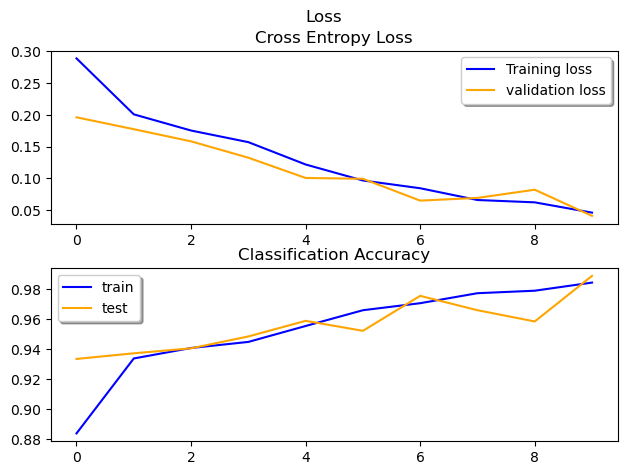

In [24]:
print("Graphs:")
summarize_diagnostics(hist)

Validation dataset confusion metrics:


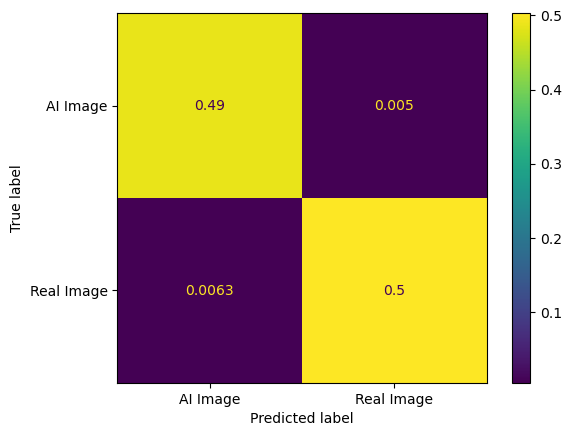

In [25]:
print("Validation dataset confusion metrics:")
print_confusion_metric(Y_true,Y_pred_classes)

In [26]:
class_names = ['Fake Image', 'Real Image']
folder="D:/Fraud Assignment/Fraud_Assignment_HA/casia/"
paths=glob.glob(folder+"*/*/*.jpg")
paths.append(glob.glob(folder+"*.png"))

1/1 [==============================] - 0s 30ms/step



File Name: D:/Fraud Assignment/Fraud_Assignment_HA/casia\CASIA2\Tp\Tp_D_CRN_M_N_art10113_cha00067_11650.jpg
Confidence: 100.00
Predicted Class: Real Image
Actual Class: Fake Image


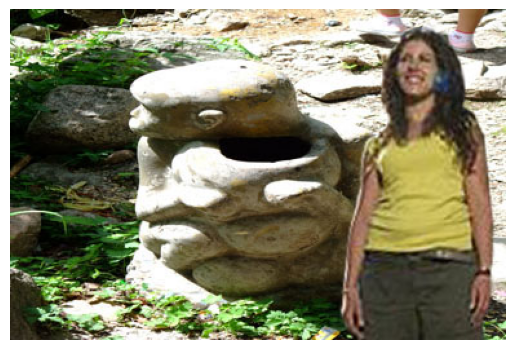

In [38]:
path=random.choice(paths)

plt.imshow(Image.open(path))
plt.axis('off')
image = prepare_image(path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
y_true="Real Image" if ('Au' in path) else "Fake Image"

print("\n\n")
print(f'File Name: {path}')
print(f'Confidence: {np.amax(y_pred) * 100:0.2f}')
print(f'Predicted Class: {class_names[y_pred_class]}')
print(f'Actual Class: {y_true}')

In [28]:
import os
from PIL import Image
import exifread
import pandas as pd
from datetime import datetime

# Define the paths to the two directories
dataset_paths = [
    "D:/Fraud Assignment/Fraud_Assignment_HA/casia/CASIA1/Sp/",
    "D:/Fraud Assignment/Fraud_Assignment_HA/casia/CASIA2/Tp/"
]

# Step 2: Extract Metadata
def extract_metadata(image_path):
    with open(image_path, 'rb') as image_file:
        tags = exifread.process_file(image_file)
    return tags

# Step 3: Extract Creation Date/Time, Software Used, and Date Modified
def extract_metadata_details(image_path):
    metadata = extract_metadata(image_path)
    
    creation_time = metadata.get('EXIF DateTimeOriginal', None)
    software_used = metadata.get('Image Software', None)
    
    # Extract Date Modified using os.path.getmtime and convert to a readable format
    date_modified_timestamp = os.path.getmtime(image_path)
    date_modified = datetime.fromtimestamp(date_modified_timestamp).strftime('%Y-%m-%d %H:%M:%S')
    
    return {
        'Creation Date/Time': str(creation_time),
        'Software Used': str(software_used),
        'Date Modified': date_modified,
    }

# Step 4: Cross-Check Metadata (Simplified example)
def cross_check_metadata(metadata, external_source):
    # Perform external source cross-checking logic here
    pass

# Step 5: Use Metadata as a Feature (Simplified example)
def use_metadata_as_feature(metadata):
    # Incorporate metadata as a feature in your detection model
    pass

# Step 6: Consider Limitations (Document limitations in your project)

# Step 7: Evaluate and Test (Simplified example)
def evaluate_and_save_to_csv(dataset_paths, output_csv_file):
    results = []

    for dataset_path in dataset_paths:
        for image_filename in os.listdir(dataset_path):
            image_path = os.path.join(dataset_path, image_filename)
            metadata_details = extract_metadata_details(image_path)
            results.append({'Image': image_filename, **metadata_details})

    # Create a DataFrame from the results
    df = pd.DataFrame(results)

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv_file, index=False)

if __name__ == "__main__":
    output_csv_file = "fake_image_metadata.csv"
    
    # Step 7: Evaluate and Test
    evaluate_and_save_to_csv(dataset_paths, output_csv_file)
    print(f"Metadata for fake images saved to {output_csv_file}")

File format not recognized.


Metadata for fake images saved to fake_image_metadata.csv


In [41]:
import os
from PIL import Image
import exifread
from datetime import datetime

# Function to perform metadata analysis on an image
def perform_metadata_analysis(image_path):
    # Extract metadata from the image
    def extract_metadata(image_path):
        with open(image_path, 'rb') as image_file:
            tags = exifread.process_file(image_file)
        return tags

    # Extract Creation Date/Time, Software Used, and Date Modified
    def extract_metadata_details(image_path):
        metadata = extract_metadata(image_path)

        creation_time = metadata.get('EXIF DateTimeOriginal', None)
        software_used = metadata.get('Image Software', None)

        # Extract Date Modified using os.path.getmtime and convert to a readable format
        date_modified_timestamp = os.path.getmtime(image_path)
        date_modified = datetime.fromtimestamp(date_modified_timestamp).strftime('%Y-%m-%d %H:%M:%S')

        return {
            'Creation Date/Time': str(creation_time),
            'Software Used': str(software_used),
            'Date Modified': date_modified,
        }

    metadata_details = extract_metadata_details(image_path)
    return metadata_details

In [42]:
# Function to determine whether an image is real or fake
def classify_image(image_path):
    # Prepare the image for classification
    image = prepare_image(image_path)
    image = image.reshape(-1, 128, 128, 3)

    # Use the trained model to predict
    prediction = model.predict(image)
    class_names = ['Fake Image', 'Real Image']
    predicted_class = class_names[np.argmax(prediction)]

    return predicted_class

if __name__ == "__main__":
    # Prompt the user to enter an image file path
    image_path = input("Enter the path of the image you want to analyze: ")

    if not os.path.exists(image_path):
        print("Image file not found.")
    else:
        # Classify the image
        classification_result = classify_image(image_path)
        print(f"Image classification result: {classification_result}")

        # Perform metadata analysis
        metadata_details = perform_metadata_analysis(image_path)
        print("\nMetadata Analysis:")
        for key, value in metadata_details.items():
            print(f"{key}: {value}")

1/1 [==============================] - 0s 29ms/step


Webp file does not have exif data.


Image classification result: Fake Image

Metadata Analysis:
Creation Date/Time: None
Software Used: None
Date Modified: 2023-09-30 03:18:01
